## Hybrid moons

This notebook demonstrates how to train a hybrid quantum classical model using the frameworks
[PennyLane](https://pennylane.ai/), [Tensorflow](https://www.tensorflow.org/)
and [Keras](https://keras.io/). The code is based on this
[tutorial](https://pennylane.ai/qml/demos/tutorial_qnn_module_tf.html). The data set is generated
with the function [make_moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html)
from sklearn.

### Setup

In [10]:
# Imports
import pennylane as qml
import tensorflow as tf
import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

In [11]:
# Set float type
tf.keras.backend.set_floatx('float64')

### Generate data

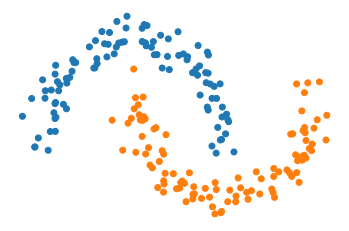

In [12]:
# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

x, y = make_moons(n_samples=200, noise=0.1)
y_hot = tf.keras.utils.to_categorical(y, num_classes=2)  # one-hot encoded labels

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]  # colours for each class
plt.axis("off")
plt.scatter(x[:, 0], x[:, 1], c=c)
plt.show()

### Define layers

Our model consists of one quantum and two classical layers. The neural network learns to
discriminate between the two sets shown above.

In [13]:
# Define a QNode for a quantum layer with 2 qubits
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [14]:
# Convert QNode to keras layer
n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

In [15]:
# Define classical layers
clayer_1 = tf.keras.layers.Dense(2)
clayer_2 = tf.keras.layers.Dense(2, activation="sigmoid")

### Train hybrid model

In [16]:
# Train hybrid neural network
model = tf.keras.models.Sequential([clayer_1, qlayer, clayer_2])
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
fitting = model.fit(x, y_hot, epochs=10, batch_size=5, validation_split=0.25, verbose=2)


Epoch 1/10
30/30 - 11s - loss: 0.6283 - accuracy: 0.6400 - val_loss: 0.3981 - val_accuracy: 0.8600
Epoch 2/10
30/30 - 10s - loss: 0.3453 - accuracy: 0.9067 - val_loss: 0.3056 - val_accuracy: 0.8600
Epoch 3/10
30/30 - 10s - loss: 0.1908 - accuracy: 0.9133 - val_loss: 0.1758 - val_accuracy: 0.9400
Epoch 4/10
30/30 - 10s - loss: 0.1142 - accuracy: 0.9667 - val_loss: 0.1005 - val_accuracy: 0.9800
Epoch 5/10
30/30 - 10s - loss: 0.2039 - accuracy: 0.9200 - val_loss: 0.3217 - val_accuracy: 0.8800
Epoch 6/10
30/30 - 10s - loss: 0.3344 - accuracy: 0.8800 - val_loss: 0.1080 - val_accuracy: 0.9800
Epoch 7/10
30/30 - 10s - loss: 0.1091 - accuracy: 0.9667 - val_loss: 0.1035 - val_accuracy: 0.9800
Epoch 8/10
30/30 - 10s - loss: 0.0951 - accuracy: 0.9733 - val_loss: 0.1279 - val_accuracy: 0.9800
Epoch 9/10
30/30 - 10s - loss: 0.1444 - accuracy: 0.9400 - val_loss: 0.0758 - val_accuracy: 0.9800
Epoch 10/10
30/30 - 10s - loss: 0.0897 - accuracy: 0.9667 - val_loss: 0.1195 - val_accuracy: 0.9600


### Training History

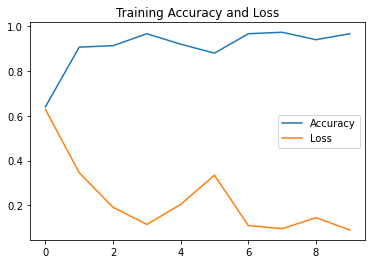

In [17]:
plt.plot(fitting.history['accuracy'], label='Accuracy')
plt.plot(fitting.history['loss'], label='Loss')
plt.legend(loc='best')
plt.title('Training Accuracy and Loss')
plt.show()

### Prediction

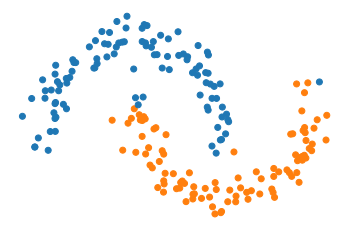

In [18]:
y_prob = model.predict(x)
y_class = y_prob.argmax(axis=-1)

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y_class]  # colours for each class
plt.axis("off")
plt.scatter(x[:, 0], x[:, 1], c=c)
plt.show()